# BeatAML

*Random Forests for SubChallenge 1*

Team: **GrauLab**

by Martin Lellep, 03/24/2020+04/07/2020

## Description

I predict each inhibitor separately and filter out all data records for which no inhibitor data exists.

Random forests are used for the regression task.

A hyperparameter grid search is used to get the best performance and k-fold validation is used to evaluate the classifier performance.

Pseudo code for what I do:

    for all inhibitors:
        for all hyperparameter configs:
            train classifier with k-fold validation
            compute mean over k-fold validation and use as achieved performance
        find best hyperparameters w.r.t. "coefficient R^2", "mean squared error" & spearman correlation performance measures

## Code

In [1]:
import pickle

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
import tqdm
import matplotlib.pyplot as plt

/import/homes/lellepgu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Settings

# Production settings
max_depth_s = [10, 50, 100, 150, 200, 300]
n_estimators_s = [10, 50, 100, 200, 300, 500, 700]
n_splits = 5

# # Test settings
# max_depth_s = [10, 12,]
# n_estimators_s = [14, 18]
# n_splits = 2

In [4]:
# Load data
data_path = '../data/sigs_inhibs_projected_untransformed.csv'

df = pd.read_csv(data_path)

signature_columns = np.array(['Signatur' in column_name for column_name in df.columns])
inhibitor_columns = np.logical_not(signature_columns)

signature_columns[22] = False # Exclude index 22 as I was told

Idea of code that follows:

* For each "Inhibitor#" column, sort out all rows that have 0 entries (as they correspond to no information)
* Build training data from the remaining data
* Set up K-fold validation
* Train classifiers on that data with different hyperparameters

Perform the computation:

In [13]:
all_data = {}

for target_inhibitor in tqdm.tqdm(range(np.count_nonzero(inhibitor_columns))):

    target_column_name = f'Inhibitor{target_inhibitor}'

    available_data = df[target_column_name] != 0.0
    df_available = df[available_data]

    y = df_available[target_column_name]

    X = df_available[df_available.columns[signature_columns]]

    y = np.array(y)
    X = np.array(X)

    mse_s =  np.zeros((len(max_depth_s), len(n_estimators_s), n_splits), dtype=float)
    c_R2_s = np.zeros((len(max_depth_s), len(n_estimators_s), n_splits), dtype=float)
    spearman_s = np.zeros((len(max_depth_s), len(n_estimators_s), n_splits), dtype=float)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

    for i_nsplits, (train_index, test_index) in enumerate(kf.split(X)):

        assert len(list(set(train_index) & set(test_index))) == 0, 'training and test data must not overlap'

        # Train and test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train models
        for i_md, max_depth in enumerate(max_depth_s):
            for i_ne, n_estimators in enumerate(n_estimators_s):

                regr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators,
                                             random_state=0, n_jobs=4)
                
                regr.fit(X_train, y_train)
                y_test_predicted = regr.predict(X_test)

                c_R2 = regr.score(X_test, y_test)
                mse = mean_squared_error(y_test, y_test_predicted)
                spearm = spearmanr(y_test, y_test_predicted).correlation
                
                c_R2_s[i_md, i_ne, i_nsplits] = c_R2
                mse_s[i_md, i_ne, i_nsplits] = mse
                spearman_s[i_md, i_ne, i_nsplits] = spearm

    all_data[target_inhibitor] = {'mse': mse_s, 'c_R2': c_R2_s, 'spearman': spearman_s}

with open('computations.pkl', 'wb') as f:
    pickle.dump(all_data, f)

Plot performances:

In [2]:
with open('computations.pkl', 'rb') as f:
    all_data = pickle.load(f)

plot_x = []
plot_y_cR2 = []
plot_y_mse = []
plot_y_spearman = []

# Take the mean over the folds and the optimal value over the hyperparameters; "optimal" depends on the metric
for k, v in all_data.items():
    plot_x.append(k)    
    plot_y_cR2.append(       v['c_R2'].mean(axis=2).max()      )
    plot_y_mse.append(       v['mse'].mean(axis=2).min()       )
    plot_y_spearman.append(  v['spearman'].mean(axis=2).max()  )
    
plot_x = np.array(plot_x)
plot_y_cR2 = np.array(plot_y_cR2)
plot_y_mse = np.array(plot_y_mse)
plot_y_spearman = np.array(plot_y_spearman)

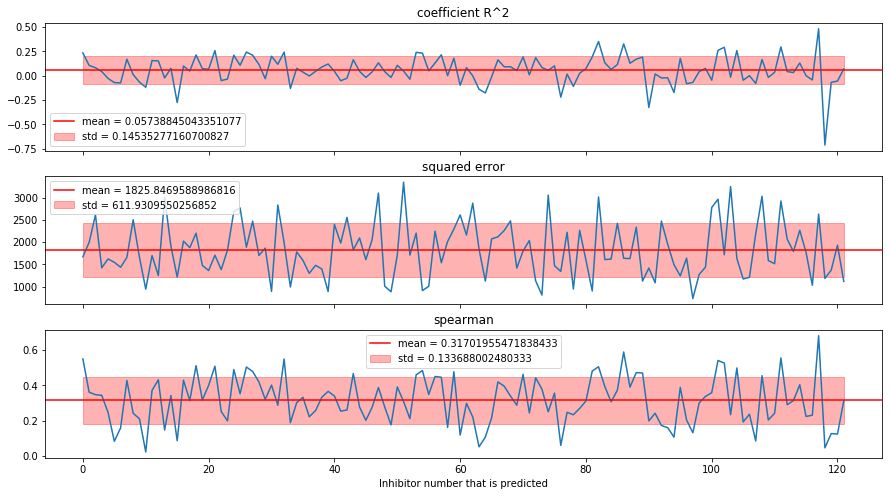

In [19]:
fig, [a_cR2, a_mse, a_spearman] = plt.subplots(3, 1, figsize=[15, 8], sharex=True)

a_cR2.plot(plot_x, plot_y_cR2)
a_mse.plot(plot_x, plot_y_mse)
a_spearman.plot(plot_x, plot_y_spearman)

a_cR2.axhline(np.mean(plot_y_cR2), ls='-', c='red', label=f'mean = {np.mean(plot_y_cR2)}')
a_mse.axhline(np.mean(plot_y_mse), ls='-', c='red', label=f'mean = {np.mean(plot_y_mse)}')
a_spearman.axhline(np.mean(plot_y_spearman), ls='-', c='red', label=f'mean = {np.mean(plot_y_spearman)}')

a_cR2.fill_between(plot_x,
                   np.mean(plot_y_cR2)-np.std(plot_y_cR2),
                   np.mean(plot_y_cR2)+np.std(plot_y_cR2),
                   color='red', alpha=0.3, label=f'std = {np.std(plot_y_cR2)}')
a_mse.fill_between(plot_x,
                   np.mean(plot_y_mse)-np.std(plot_y_mse),
                   np.mean(plot_y_mse)+np.std(plot_y_mse),
                   color='red', alpha=0.3, label=f'std = {np.std(plot_y_mse)}')
a_spearman.fill_between(plot_x,
                        np.mean(plot_y_spearman)-np.std(plot_y_spearman),
                        np.mean(plot_y_spearman)+np.std(plot_y_spearman),
                        color='red', alpha=0.3, label=f'std = {np.std(plot_y_spearman)}')

a_cR2.set_title('coefficient R^2')
a_mse.set_title('squared error')
a_spearman.set_title('spearman')

a_spearman.set_xlabel('Inhibitor number that is predicted')

a_cR2.legend()
a_mse.legend()
a_spearman.legend()

plt.show()

**Lastly:** How does this performance compare to what other people achive?